# Gesture Recognition


In [51]:
import numpy as np
import os
from skimage import io, transform
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

We set the random seed so that the results don't vary drastically.

In [52]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [53]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size =32 

In [54]:
x=30 # number of images used for each video
y,z= 120,120 # final size of the input images

### Data Understanding

In [55]:
train_doc.shape

(663,)

In [56]:
# Reading the training dictionary
train_doc[0]

'WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'

Gesture: Right_Swipe_new 
Label: 1


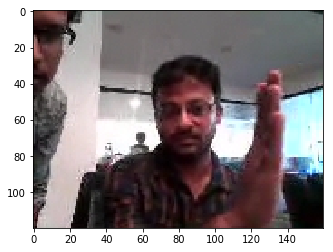

In [57]:
# Reading an image from a user specified folder and frame
num=0
imgs = os.listdir('Project_data/train'+'/'+ train_doc[num].split(';')[0])
image = io.imread('Project_data/train'+'/'+ train_doc[num].strip().split(';')[0]+'/'+imgs[1])
print('Gesture:',train_doc[num].strip().split(';')[1],'\nLabel:',train_doc[num].strip().split(';')[2])
plt.imshow(image)

### Preprocessing

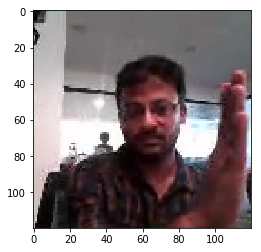

In [58]:
#cropping
cropped=image[:,20:140]
plt.imshow(cropped)

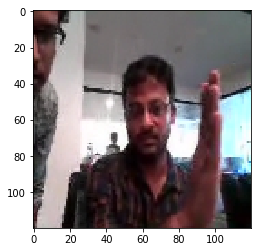

In [59]:
# resizing:
rz=transform.resize(image,(y,z))
plt.imshow(rz)

In [60]:
# Normalising
norm=(rz-rz.min())/(rz.max()-rz.min())
print('Max:',norm.max(),' Min:',norm.min())

Max: 1.0  Min: 0.0


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [61]:
# Function for loading batches of images
def func_batch(source_path, t, batch_size,batch):
    global x,y,z
    batch_data = np.zeros((batch_size,x,y,z,3))
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    img_idx=[num for num in range(x)]
                    
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image =io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                       
            # cropping 
            if image.shape[0] !=image.shape[1]:  # check if height of image not equal to width
                image=image[:,20:140]      # cropping the sides
                     
            # resizing
            im_rz = transform.resize(image,(y,z))
            
            #normalizing
            im_norm=  (im_rz-im_rz.min())/(im_rz.max()-im_rz.min())
                   
            batch_data[folder,idx,:,:,0] =im_rz[:,:,0]
            batch_data[folder,idx,:,:,1] =im_rz[:,:,1]
            batch_data[folder,idx,:,:,2] =im_rz[:,:,2]
                    
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels


In [62]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches =len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            yield func_batch(source_path, t, batch_size,batch)
        
        # write the code for the remaining data points which are left after full batches
        rem= len(folder_list)%batch_size
        if rem > 0:
            batch_size=rem
            yield func_batch(source_path, t, batch_size,batch)
        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [63]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [64]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras import optimizers
from keras.layers.pooling import GlobalAveragePooling2D

### Model 1:  3D CNN

#### Initial Architecture

- Let us start with a network comprising 3 layers of CNN with varying number of filters- 8(3x3x3),16(3x3x3) and 32(3x3x3). 
- Padding is used to preserve the dimesnions
- Each of these are separated by a MaxPooling layer to keep the number of trainable parameters as low as possible. 
- A flattening layer and 3 layers of dense networks (1 output) follow them
- Dropout(25%) is included only for the first dense network. 
- All the layers excpet the output use ReLu activation function while the output layer  has softmax activation.
- Adam optimiser is chosen
- Batch normalisation is not applied.

In [15]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))

mod_3d.add(Activation('relu'))

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))

mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten
mod_3d.add(Flatten())

# Dense
mod_3d.add(Dense(128, activation= 'relu'))
mod_3d.add(Dropout(0.25))
mod_3d.add(Dense(64, activation= 'relu'))

# Output
mod_3d.add(Dense(5, activation= 'softmax'))


# Complie
optimiser = optimizers.Adam()
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 30, 30, 32)     13856     
__________

This architecture contains 2,791,493 trainable parameters

### Training experiments 

Before finalising the architecture of the model, experiments will be carried out on a small portion of a dataset 
(330 training and 50 validation sets). The model will be made to overfit during experimenatl phase. The trainig will be conducted only for 10 epochs. During experimental pahse, models are not saved.
 

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [136]:
train_doc_expt = train_doc[:330]
val_doc_expt = val_doc[:50]

train_generator = generator(train_path, train_doc_expt, batch_size)
val_generator = generator(val_path, val_doc_expt, batch_size)


In [137]:
num_train_sequences = len(train_doc_expt)
num_val_sequences = len(val_doc_expt)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [138]:
# Function to plot the learning curves
def plot_history(history):
    fig,axes = plt.subplots(1,2, figsize = (15, 5))   
    # plotting loss
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # plotting accuracy
    plt.subplot(122)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')


In [139]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
callbacks_list = [LR]

##### Fitting Architecture 1

In [20]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 32
Epoch 1/10
 Project_data/val ; batch size = 32
11/11 [==============================] - 163s 15s/step - loss: 13.3576 - categorical_accuracy: 0.1657 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800
Epoch 2/10
11/11 [==============================] - 24s 2s/step - loss: 13.0410 - categorical_accuracy: 0.1909 - val_loss: 13.4317 - val_categorical_accuracy: 0.1667
Epoch 3/10
11/11 [==============================] - 26s 2s/step - loss: 12.6014 - categorical_accuracy: 0.2182 - val_loss: 12.6642 - val_categorical_accuracy: 0.2143
Epoch 4/10
11/11 [==============================] - 25s 2s/step - loss: 13.9202 - categorical_accuracy: 0.1364 - val_loss: 13.2399 - val_categorical_accuracy: 0.1786
Epoch 5/10
11/11 [==============================] - 24s 2s/step - loss: 13.0410 - categorical_accuracy: 0.1909 - val_loss: 15.1107 - val_categorical_accuracy: 0.0625
Epoch 6/10
11/11 [==============================] - 23s 2s/step - 

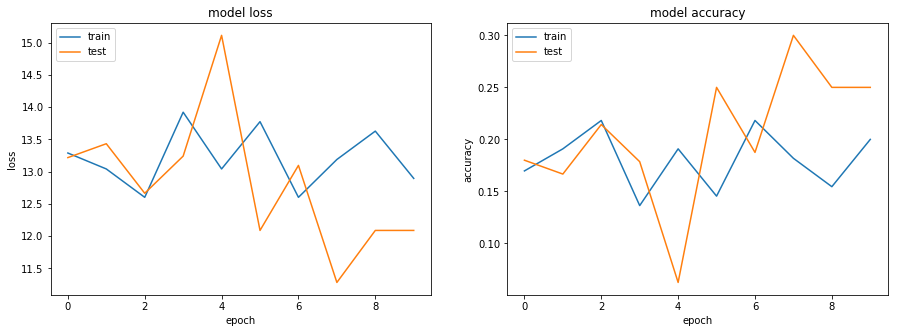

In [21]:
plot_history(history)

Inspite of having around 2.8 million parameters, the maximum training accuracy is 0.2 and validation accuracy is 0.25.  The model is not bale to learn the given data. Let us add batch normalisation to check if it improves the accuracy

#### Experiment 1: Batch Normalisation :  

Including Batch normalisation for each layer to check if it improves the model performance. 

In [34]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())


mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(128, activation= 'relu'))
mod_3d.add(Dropout(0.25))

mod_3d.add(Dense(64, activation= 'relu'))

# Output
mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/10
11/11 [==============================] - 76s 7s/step - loss: 4.9546 - categorical_accuracy: 0.3343 - val_loss: 5.1709 - val_categorical_accuracy: 0.4000
Epoch 2/10
11/11 [==============================] - 22s 2s/step - loss: 2.9598 - categorical_accuracy: 0.4818 - val_loss: 3.0087 - val_categorical_accuracy: 0.5556
Epoch 3/10
11/11 [==============================] - 19s 2s/step - loss: 2.5469 - categorical_accuracy: 0.4545 - val_loss: 2.4119 - val_categorical_accuracy: 0.5000
Epoch 4/10
11/11 [==============================] - 20s 2s/step - loss: 2.7988 - categorical_accuracy: 0.4455 - val_loss: 3.0796 - val_categorical_accuracy: 0.5357
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 1.9998 - categorical_accuracy: 0.5273 - val_loss: 2.2170 - val_categorical_accuracy: 0.4375
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 1.5074

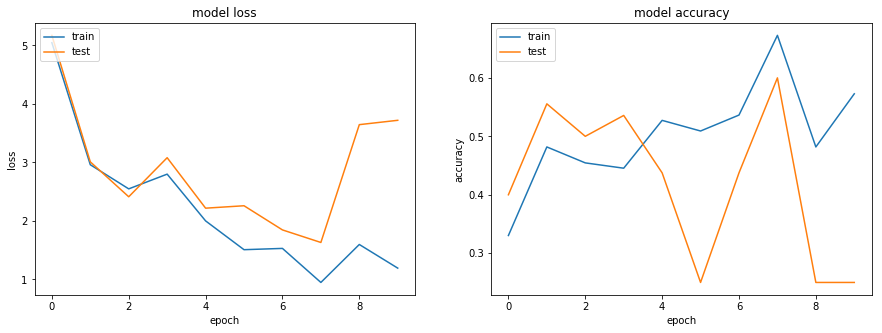

In [36]:
plot_history(history)

- Batch normalisation reduces the compiling time by ~ 5s/epoch. 
- It also increases training accuracy from 0.2 to 0.57 while the validation accuracy remains at 0.25. However, it is clear that add batch normalisation helps the model to learn and overfit on the trainig data.

Now let us add another layer of feature maps to check if the accuracy improves

#### Experiment 2: Add another layer of 64 feature maps and MaxPooling:


In [62]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(128, activation= 'relu'))
mod_3d.add(Dropout(0.25))

mod_3d.add(Dense(64, activation= 'relu'))
# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()#(lr=learning_rate,clipvalue=1.0)
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_11 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_12 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 60, 60, 16)    64        
__________

In [63]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/10
11/11 [==============================] - 70s 6s/step - loss: 2.3184 - categorical_accuracy: 0.3000 - val_loss: 1.6334 - val_categorical_accuracy: 0.5000
Epoch 2/10
11/11 [==============================] - 19s 2s/step - loss: 1.2110 - categorical_accuracy: 0.5000 - val_loss: 1.3022 - val_categorical_accuracy: 0.4444
Epoch 3/10
11/11 [==============================] - 19s 2s/step - loss: 1.4188 - categorical_accuracy: 0.4455 - val_loss: 1.8750 - val_categorical_accuracy: 0.3214
Epoch 4/10
11/11 [==============================] - 19s 2s/step - loss: 1.4895 - categorical_accuracy: 0.3909 - val_loss: 1.5436 - val_categorical_accuracy: 0.3214
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 1.1368 - categorical_accuracy: 0.5636 - val_loss: 1.2527 - val_categorical_accuracy: 0.3750
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 1.1682

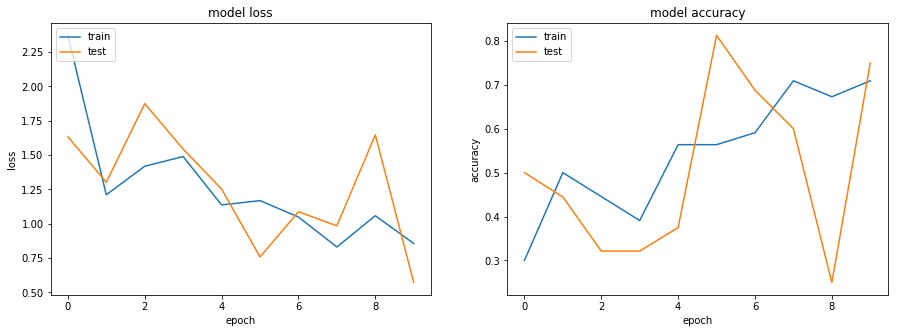

In [64]:
plot_history(history)

- The number of trainable parameters have come down to 483,701.
- Training accuracy has increased to 0.7 from 0.57 , which is desirable.
- The validation accuracy has gone upto 0.75 which may be due to the presence of dropout after dense network.  
- Let us add another layer of feature map to check if accuracy can be increased further

#### Experiment 3: Add another layer of 64 feature maps after the third layer without MaxPooling:
Adding another feature map with a max pooling layer will introduce negative dmension error as the size of the input data has reduced considerably

In [101]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))
mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())


mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(128, activation= 'relu'))
mod_3d.add(Dropout(0.25))
mod_3d.add(Dense(64, activation= 'relu'))
# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_24 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_25 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 60, 60, 16)    64        
__________

The total number of parameters increase to 594,485

In [102]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train Epoch 1/10
; batch size = 32
11/11 [==============================] - 76s 7s/step - loss: 2.4730 - categorical_accuracy: 0.3486 - val_loss: 2.4923 - val_categorical_accuracy: 0.3600
Epoch 2/10
11/11 [==============================] - 19s 2s/step - loss: 1.0719 - categorical_accuracy: 0.5455 - val_loss: 1.6206 - val_categorical_accuracy: 0.5000
Epoch 3/10
11/11 [==============================] - 19s 2s/step - loss: 1.3003 - categorical_accuracy: 0.4818 - val_loss: 2.1028 - val_categorical_accuracy: 0.4286
Epoch 4/10
11/11 [==============================] - 21s 2s/step - loss: 1.5108 - categorical_accuracy: 0.4364 - val_loss: 1.3862 - val_categorical_accuracy: 0.5000
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 1.0981 - categorical_accuracy: 0.5545 - val_loss: 1.0756 - val_categorical_accuracy: 0.5000
Epoch 6/10
11/11 [==============================] - 19s 2s/step - loss: 0.8666

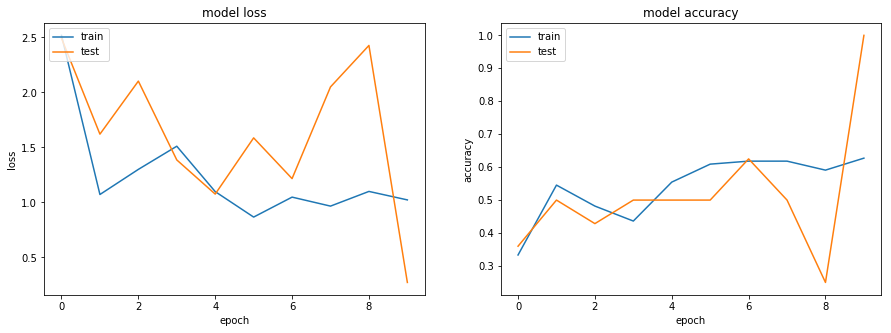

In [103]:
plot_history(history)

Adding another layer of feature map reduced the trainig accuracy from 0.7 to 0.62 and made the validation accuracy 1.The feature map doesn't decrease the trianig loss. This may be due to vanishing gradients.

So let us remove it and add increase the number of neurons in the dense network instead of adding another layer.

#### Experiment 4: Increase neurons in first dense network:

In [114]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))

mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())


mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(256, activation= 'relu'))
mod_3d.add(Dropout(0.25))
mod_3d.add(Dense(64, activation= 'relu'))
# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_29 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_30 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 15, 60, 60, 16)    64        
__________

The total number of trainable parameters increase to 893,669

In [115]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Epoch 1/10Project_data/train ; batch size = 32

11/11 [==============================] - 75s 7s/step - loss: 2.2691 - categorical_accuracy: 0.3829 - val_loss: 2.0099 - val_categorical_accuracy: 0.4200
Epoch 2/10
11/11 [==============================] - 21s 2s/step - loss: 1.2732 - categorical_accuracy: 0.5273 - val_loss: 1.4827 - val_categorical_accuracy: 0.5000
Epoch 3/10
11/11 [==============================] - 22s 2s/step - loss: 1.3794 - categorical_accuracy: 0.5091 - val_loss: 1.3340 - val_categorical_accuracy: 0.5000
Epoch 4/10
11/11 [==============================] - 22s 2s/step - loss: 1.7098 - categorical_accuracy: 0.4818 - val_loss: 1.1122 - val_categorical_accuracy: 0.4643
Epoch 5/10
11/11 [==============================] - 21s 2s/step - loss: 1.2445 - categorical_accuracy: 0.5727 - val_loss: 1.5755 - val_categorical_accuracy: 0.6250
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 0.9073

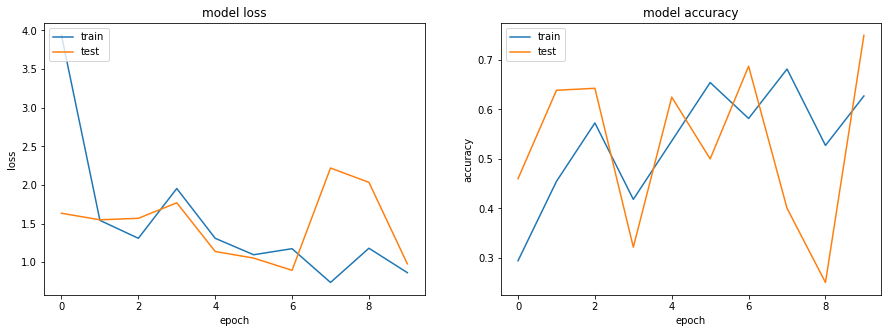

In [90]:
plot_history(history)

The trainig accuracy increases from 0.7 to 0.74.

Let us increase the number of neurons in the second dense network and check if the combination of these two can increase the training accuracy of the model.

#### Experiment 5: Increase neurons in second dense network:

In [140]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))

mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(256, activation= 'relu'))
mod_3d.add(Dropout(0.25))
mod_3d.add(Dense(128, activation= 'relu'))
# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()#(lr=learning_rate,clipvalue=1.0)
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_37 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_35 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_38 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 15, 60, 60, 16)    64        
__________

In [141]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = Source path =  Project_data/train32
 ; batch size = Epoch 1/10
32
11/11 [==============================] - 75s 7s/step - loss: 2.1621 - categorical_accuracy: 0.3686 - val_loss: 1.2282 - val_categorical_accuracy: 0.5000
Epoch 2/10
11/11 [==============================] - 21s 2s/step - loss: 1.4333 - categorical_accuracy: 0.5182 - val_loss: 2.0623 - val_categorical_accuracy: 0.6111
Epoch 3/10
11/11 [==============================] - 19s 2s/step - loss: 1.2543 - categorical_accuracy: 0.5091 - val_loss: 1.5641 - val_categorical_accuracy: 0.4643
Epoch 4/10
11/11 [==============================] - 22s 2s/step - loss: 1.4625 - categorical_accuracy: 0.4545 - val_loss: 1.0290 - val_categorical_accuracy: 0.6429
Epoch 5/10
11/11 [==============================] - 21s 2s/step - loss: 0.9443 - categorical_accuracy: 0.6273 - val_loss: 1.4073 - val_categorical_accuracy: 0.6250
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 0.7722

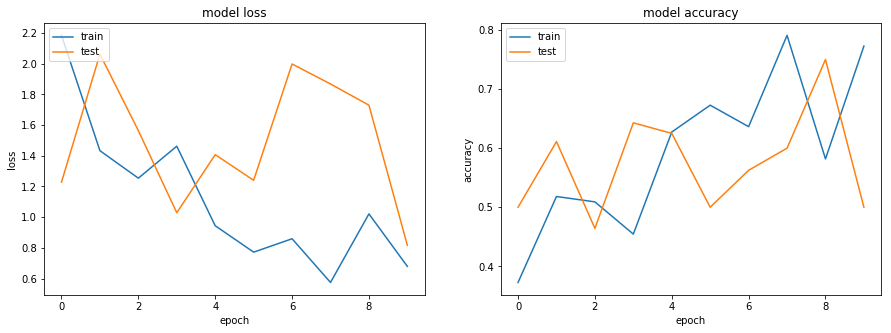

In [142]:
plot_history(history)

Training accuracy increases from 0.74 to 0.77   

Since this architecture is able to generalize well on a small dataset and produce an accuracy of more than 70% with less than 1 million parameters, this will be used for final fitting on the entire dataset.

### Training the final architeture of the model

In [150]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))

mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())


mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(256, activation= 'relu'))
mod_3d.add(Dropout(0.25))
mod_3d.add(Dense(128, activation= 'relu'))
# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()#(lr=learning_rate,clipvalue=1.0)
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_41 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_42 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 15, 60, 60, 16)    64        
__________

In [197]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [198]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [199]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Fitting the final architecture on the entire dataset

In [154]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - 215s 10s/step - loss: 1.9141 - categorical_accuracy: 0.3875 - val_loss: 1.3565 - val_categorical_accuracy: 0.4700
Epoch 2/10
21/21 [==============================] - 90s 4s/step - loss: 0.9653 - categorical_accuracy: 0.6087 - val_loss: 1.2702 - val_categorical_accuracy: 0.5000
Epoch 3/10
21/21 [==============================] - 76s 4s/step - loss: 0.8529 - categorical_accuracy: 0.6810 - val_loss: 2.5542 - val_categorical_accuracy: 0.5000
Epoch 4/10
21/21 [==============================] - 69s 3s/step - loss: 0.8051 - categorical_accuracy: 0.6892 - val_loss: 0.7532 - val_categorical_accuracy: 0.6250
Epoch 5/10
21/21 [==============================] - 67s 3s/step - loss: 0.5985 - categorical_accuracy: 0.7787 - val_loss: 1.5080 - val_categorical_accuracy: 0.6250
Epoch 6/10
21/21 [==============================] - 64s 3s/step - loss: 0.57

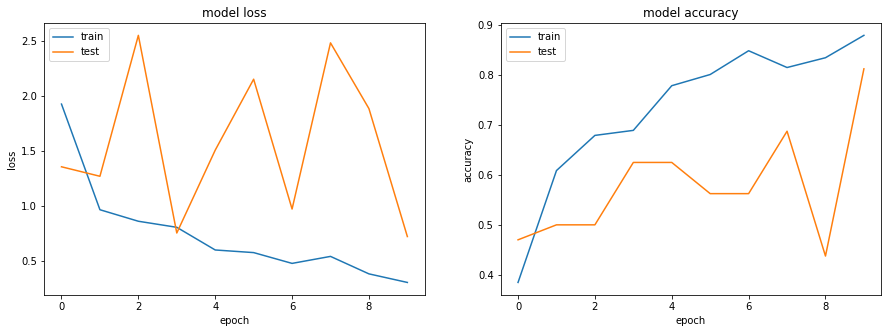

In [155]:
plot_history(history)

The training accuracy is 0.87 and validation accuracy is 0.81. The model overfits slightly. So let us fine  tune the model by increasing the droput after dense network

#### Controlling  overfitting

#### Increase Droput after dense network 

In [187]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))

mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())



mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(256, activation= 'relu'))
mod_3d.add(Dropout(0.5))
mod_3d.add(Dense(128, activation= 'relu'))

# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_53 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_51 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_54 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 15, 60, 60, 16)    64        
__________

In [188]:

history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 32
 ; batch size = 32
Epoch 1/10
21/21 [==============================] - 129s 6s/step - loss: 2.4230 - categorical_accuracy: 0.3480 - val_loss: 2.0953 - val_categorical_accuracy: 0.3900
Epoch 2/10
21/21 [==============================] - 92s 4s/step - loss: 1.3025 - categorical_accuracy: 0.5176 - val_loss: 1.1918 - val_categorical_accuracy: 0.6875
Epoch 3/10
21/21 [==============================] - 79s 4s/step - loss: 1.0540 - categorical_accuracy: 0.5593 - val_loss: 0.9458 - val_categorical_accuracy: 0.6875
Epoch 4/10
21/21 [==============================] - 77s 4s/step - loss: 1.0636 - categorical_accuracy: 0.5965 - val_loss: 1.2935 - val_categorical_accuracy: 0.4375
Epoch 5/10
21/21 [==============================] - 68s 3s/step - loss: 0.9871 - categorical_accuracy: 0.6246 - val_loss: 1.0018 - val_categorical_accuracy: 0.6875
Epoch 6/10
21/21 [==============================] - 68s 3s/step - loss: 0.852

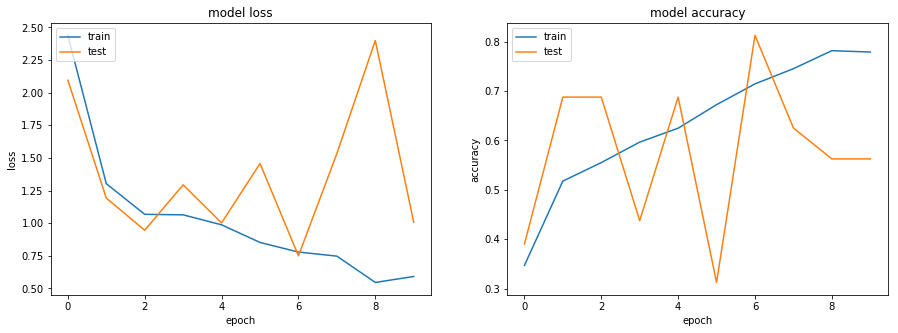

In [189]:
 plot_history(history)

While, the model still overfits, the accuracy of the model has gone down. So let us reduce the droput after dense network and introduce it after the last feature map.

#### Introduce drop out in convolution layers

In [200]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))

mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())


mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))

mod_3d.add(Dropout(0.25))

mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(256, activation= 'relu')) # 
mod_3d.add(Dropout(0.25))

mod_3d.add(Dense(128, activation= 'relu'))

# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_57 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_55 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_58 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 15, 60, 60, 16)    64        
__________

In [201]:
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  Project_data/train ; batch size = 32
Project_data/val ; batch size = 32
Epoch 1/10
21/21 [==============================] - 131s 6s/step - loss: 2.4030 - categorical_accuracy: 0.3425 - val_loss: 1.2142 - val_categorical_accuracy: 0.5100
Epoch 2/10
21/21 [==============================] - 91s 4s/step - loss: 1.1999 - categorical_accuracy: 0.4700 - val_loss: 1.1524 - val_categorical_accuracy: 0.5000
Epoch 3/10
21/21 [==============================] - 80s 4s/step - loss: 0.9820 - categorical_accuracy: 0.5806 - val_loss: 1.2020 - val_categorical_accuracy: 0.5625
Epoch 4/10
21/21 [==============================] - 77s 4s/step - loss: 0.9759 - categorical_accuracy: 0.5865 - val_loss: 0.9277 - val_categorical_accuracy: 0.5000
Epoch 5/10
21/21 [==============================] - 69s 3s/step - loss: 0.8384 - categorical_accuracy: 0.7171 - val_loss: 1.2353 - val_categorical_accuracy: 0.5000
Epoch 6/10
21/21 [==============================] - 66s 3s/step - loss: 0.852

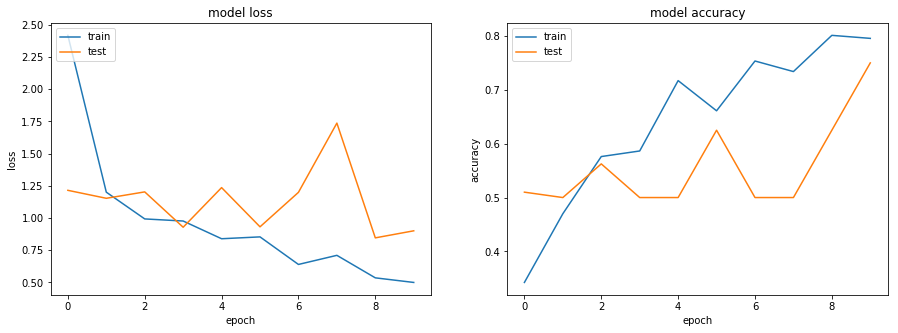

In [202]:
plot_history(history)

The training accuacy is 0.79 and validation accuracy is 0.75 with dropouts after 2 layeres. this model will be more robust and hence this is selected for final run

## Final run on the Final Architecture  (3D CNN)

The model seems to be performing better. Let us run the same model for 50 epochs and hence early stopping is used.

In [71]:
mod_3d= Sequential()

mod_3d.add(Conv3D (filters=8,kernel_size=(3,3,3), 
                  input_shape=(x,y,z,3) ,
                  padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))


mod_3d.add(Conv3D (filters=16,
                   kernel_size=(3,3,3), 
                  padding='same'))

mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())


mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=32,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))
mod_3d.add(BatchNormalization())

mod_3d.add(MaxPooling3D((2,2,2)))

mod_3d.add(Conv3D (filters=64,
                   kernel_size=(3,3,3), 
                   padding='same'))
mod_3d.add(Activation('relu'))

mod_3d.add(Dropout(0.25))

mod_3d.add(MaxPooling3D((2,2,2)))

# Faltten

mod_3d.add(Flatten())


# Dense
mod_3d.add(Dense(256, activation= 'relu')) # 
mod_3d.add(Dropout(0.25))

mod_3d.add(Dense(128, activation= 'relu'))

# Output

mod_3d.add(Dense(5, activation= 'softmax'))

optimiser = optimizers.Adam()
mod_3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mod_3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 60, 60, 16)    64        
__________

In [72]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [73]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
ES = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=10)
callbacks_list = [checkpoint,LR]

In [74]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [75]:
# Running for 50 epochs
num_epochs=50
history=mod_3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 128s 6s/step - loss: 1.9299 - categorical_accuracy: 0.3700 - val_loss: 1.2051 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-05-2517_04_38.872820/model-00001-1.94091-0.36802-1.20506-0.47000.h5
Epoch 2/30
21/21 [==============================] - 59s 3s/step - loss: 1.1536 - categorical_accuracy: 0.5383 - val_loss: 0.9911 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-05-2517_04_38.872820/model-00002-1.15362-0.53830-0.99106-0.50000.h5
Epoch 3/30
21/21 [==============================] - 66s 3s/step - loss: 1.0906 - categorical_accuracy: 0.5469 - val_loss: 1.2381 - val_categorical_accuracy: 0.4375

Epoch 00003: saving model to model_init_2020-05-2517_04_38.872820/model-00003-1.08897-0.54801-1.23812-0.43750.h5
Epoch 4/30
21/21 [==============================] - 73s 3s/step


Epoch 00029: saving model to model_init_2020-05-2517_04_38.872820/model-00029-0.05920-0.98319-0.77429-0.75000.h5
Epoch 30/30
21/21 [==============================] - 57s 3s/step - loss: 0.0464 - categorical_accuracy: 0.9916 - val_loss: 0.8606 - val_categorical_accuracy: 0.6875

Epoch 00030: saving model to model_init_2020-05-2517_04_38.872820/model-00030-0.04643-0.99160-0.86064-0.68750.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


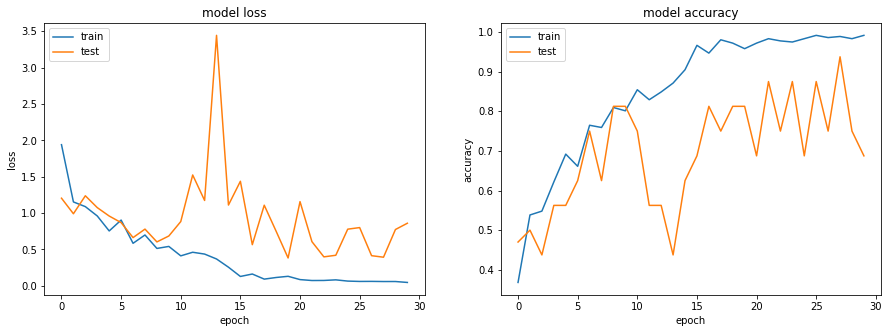

In [76]:
plot_history(history )

## Model 2 : CNN+RNN

A pretrained model is used for 2D CNN network which is then connected to GRU.
The CNN network used is MobileNetV2 which has minimum number of parameters (3,538,984) among all other networks available in Keras API. Since our model has to be used in web camera, using the lightest one that gives a high accuracy is desired and hence this network is selected
GRU has less number of parameters than LSTM and hence GRU is used as RNN

##### Initial architecture :
The pretrained MobileNetV2 model is used as base model. Te output of the model is normalised and fed to a global average pooling layer. This is followed by a Flattening layer,GRU of size 32, a dense network of size 128 and a dense network of size 5. 

In [16]:
from keras.applications import MobileNetV2

In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
  
model = Sequential()
   
model.add(TimeDistributed(base_model, input_shape=(x, y, z, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(TimeDistributed(Flatten()))
    
model.add(GRU(32, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1280)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1280)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                126048    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
__________

In [38]:
batch_size=8 # batch size of 64,32 and 16 produced a memory error
train_doc_expt=train_doc[:330]
val_doc_expt=val_doc[:50]
train_generator = generator(train_path, train_doc_expt, batch_size)
val_generator = generator(val_path, val_doc_expt, batch_size)

In [39]:
num_train_sequences = len(train_doc_expt)
num_val_sequences = len(val_doc_expt)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
callbacks_list = [LR]

In [44]:
# Function to plot the learning curves
def plot_history(history):
    fig,axes = plt.subplots(1,2, figsize = (15, 5))   
    # plotting loss
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # plotting accuracy
    plt.subplot(122)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')


In [20]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, 
                    initial_epoch=0)


Source path = Source path =  Project_data/train ; batch size = 8 Project_data/val ; batch size = 8
Epoch 1/10

42/42 [==============================] - 160s 4s/step - loss: 1.4851 - categorical_accuracy: 0.3571 - val_loss: 1.2645 - val_categorical_accuracy: 0.4000
Epoch 2/10
42/42 [==============================] - 20s 475ms/step - loss: 1.4526 - categorical_accuracy: 0.3333 - val_loss: 1.3067 - val_categorical_accuracy: 0.4286
Epoch 3/10
42/42 [==============================] - 24s 562ms/step - loss: 1.4162 - categorical_accuracy: 0.4167 - val_loss: 1.2216 - val_categorical_accuracy: 0.4286
Epoch 4/10
42/42 [==============================] - 24s 564ms/step - loss: 1.3627 - categorical_accuracy: 0.4048 - val_loss: 1.2028 - val_categorical_accuracy: 0.7143
Epoch 5/10
42/42 [==============================] - 23s 542ms/step - loss: 1.4246 - categorical_accuracy: 0.4286 - val_loss: 1.6104 - val_categorical_accuracy: 0.2143
Epoch 6/10
42/42 [==============================] - 21s 508ms/step 

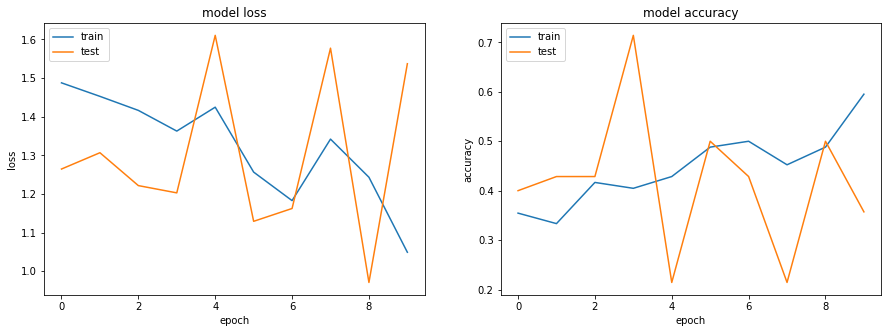

In [21]:
plot_history(history)

The training accuracy is only 0.55 and the validation accuracy is 0.21. Let us increase the size of GRU to 64 to determins if it improves the accuracy.

#### Experiment 1 : Increasing the size of GRU to 64

In [42]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
  
model = Sequential()
   
model.add(TimeDistributed(base_model, input_shape=(x, y, z, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(TimeDistributed(Flatten()))
    
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 1280)          0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 1280)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                258240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
__________

In [43]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, 
                    initial_epoch=0)

Source path =  Project_data/val ; batch size = 8
Source path =  Project_data/trainEpoch 1/10 ; batch size = 8

42/42 [==============================] - 74s 2s/step - loss: 1.4680 - categorical_accuracy: 0.3452 - val_loss: 1.1355 - val_categorical_accuracy: 0.6200
Epoch 2/10
42/42 [==============================] - 15s 360ms/step - loss: 1.4841 - categorical_accuracy: 0.3810 - val_loss: 1.5751 - val_categorical_accuracy: 0.2857
Epoch 3/10
42/42 [==============================] - 17s 395ms/step - loss: 1.4323 - categorical_accuracy: 0.3690 - val_loss: 1.2293 - val_categorical_accuracy: 0.5714
Epoch 4/10
42/42 [==============================] - 18s 431ms/step - loss: 1.3234 - categorical_accuracy: 0.4286 - val_loss: 1.7500 - val_categorical_accuracy: 0.2143
Epoch 5/10
42/42 [==============================] - 18s 423ms/step - loss: 1.3628 - categorical_accuracy: 0.3929 - val_loss: 1.5766 - val_categorical_accuracy: 0.2143
Epoch 6/10
42/42 [==============================] - 17s 415ms/step -

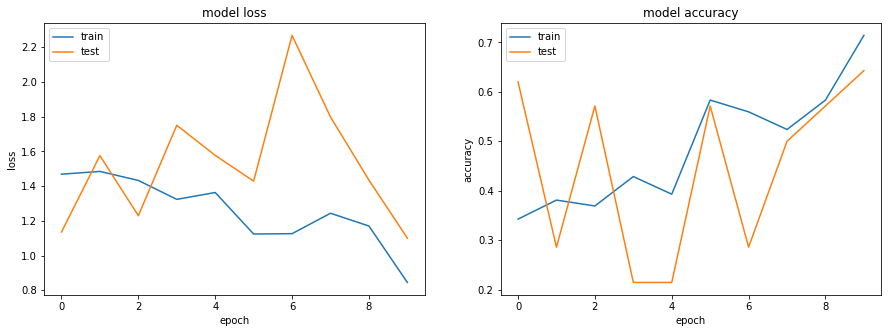

In [44]:
plot_history(history)

The training accuracy has increased from 0.59 to 0.71 . So let us freeze this architecture and fine tune it while fitting the entire data on it .

#### Fitting the entire data on CNN+RNN architecture

In [73]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
  
model = Sequential()
   
model.add(TimeDistributed(base_model, input_shape=(x, y, z, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(TimeDistributed(Flatten()))
    
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 1280)          0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 1280)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                258240    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
__________

In [53]:
batch_size=8
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [54]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, 
                    initial_epoch=0)


Source path =  Source path =  Project_data/val ; batch size = 8
Epoch 1/10
Project_data/train ; batch size = 8
83/83 [==============================] - 212s 3s/step - loss: 1.2979 - categorical_accuracy: 0.4578 - val_loss: 0.8830 - val_categorical_accuracy: 0.6700
Epoch 2/10
83/83 [==============================] - 108s 1s/step - loss: 0.6815 - categorical_accuracy: 0.8055 - val_loss: 0.6065 - val_categorical_accuracy: 0.8077
Epoch 3/10
83/83 [==============================] - 87s 1s/step - loss: 0.5564 - categorical_accuracy: 0.8213 - val_loss: 0.5445 - val_categorical_accuracy: 0.8462
Epoch 4/10
83/83 [==============================] - 76s 915ms/step - loss: 0.6460 - categorical_accuracy: 0.7680 - val_loss: 1.8793 - val_categorical_accuracy: 0.3846
Epoch 5/10
83/83 [==============================] - 54s 655ms/step - loss: 0.7897 - categorical_accuracy: 0.6506 - val_loss: 1.8473 - val_categorical_accuracy: 0.3269
Epoch 6/10
83/83 [==============================] - 51s 616ms/step - los

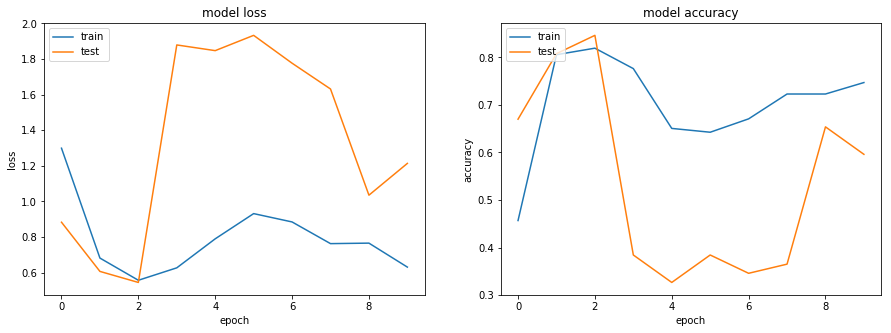

In [56]:
plot_history(history)

 Since the  model overfits, letus increase the droput to control it

#### Increasing the dropout to 0.5 to control overfitting

In [10]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
  
model = Sequential()
   
model.add(TimeDistributed(base_model, input_shape=(x, y, z, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(TimeDistributed(Flatten()))
    
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

9412608/9406464 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1280)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1280)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                258240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dens

In [11]:
batch_size=8
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)

callbacks_list = [LR]
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, 
                    initial_epoch=0)


Source path =  Project_data/val ; batch size = 8
Source path =  Project_data/train ; batch size = 8
Epoch 1/10
83/83 [==============================] - 274s 3s/step - loss: 1.3697 - categorical_accuracy: 0.4124 - val_loss: 1.1552 - val_categorical_accuracy: 0.4500
Epoch 2/10
83/83 [==============================] - 112s 1s/step - loss: 0.8173 - categorical_accuracy: 0.7298 - val_loss: 0.7360 - val_categorical_accuracy: 0.6923
Epoch 3/10
83/83 [==============================] - 89s 1s/step - loss: 0.6454 - categorical_accuracy: 0.7859 - val_loss: 0.7552 - val_categorical_accuracy: 0.6538
Epoch 4/10
83/83 [==============================] - 77s 926ms/step - loss: 0.7620 - categorical_accuracy: 0.7037 - val_loss: 1.1410 - val_categorical_accuracy: 0.6346
Epoch 5/10
83/83 [==============================] - 55s 663ms/step - loss: 0.9614 - categorical_accuracy: 0.5944 - val_loss: 1.2211 - val_categorical_accuracy: 0.5192
Epoch 6/10
83/83 [==============================] - 52s 627ms/step - los

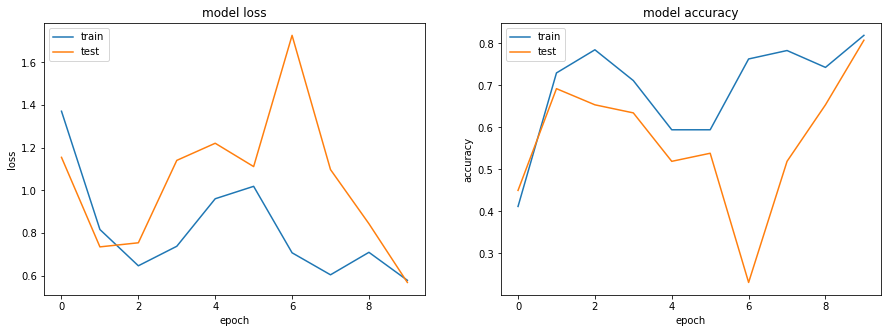

In [16]:
plot_history(history)

Both the training and validation accuracy are ~ 80%. So let us freeze this architecture and run it for 50 epochs and save the models. Early Stopping is being used as the model runs for 50 epochs

## Final Run on the Final Architecture (CNN+RNN)

In [65]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
  
model = Sequential()
   
model.add(TimeDistributed(base_model, input_shape=(x, y, z, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(TimeDistributed(Flatten()))
    
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 1280)          0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 1280)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                258240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
__________

In [66]:
batch_size=8
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [67]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [68]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
ES = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=10)
callbacks_list = [checkpoint,LR]

In [69]:
# Running for 50 epochs
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, 
                    initial_epoch=0)


Source path =  Project_data/val ; batch size = 8
Source path =  Project_data/train ; batch size = 8
Epoch 1/50
83/83 [==============================] - 140s 2s/step - loss: 1.3527 - categorical_accuracy: 0.4367 - val_loss: 1.0072 - val_categorical_accuracy: 0.6300

Epoch 00001: saving model to model_init_2020-05-2517_04_38.872820/model-00001-1.35407-0.43590-1.00716-0.63000.h5
Epoch 2/50
83/83 [==============================] - 99s 1s/step - loss: 0.7999 - categorical_accuracy: 0.7057 - val_loss: 0.6600 - val_categorical_accuracy: 0.7885

Epoch 00002: saving model to model_init_2020-05-2517_04_38.872820/model-00002-0.79992-0.70568-0.65999-0.78846.h5
Epoch 3/50
83/83 [==============================] - 84s 1s/step - loss: 0.6774 - categorical_accuracy: 0.7707 - val_loss: 0.4299 - val_categorical_accuracy: 0.8654

Epoch 00003: saving model to model_init_2020-05-2517_04_38.872820/model-00003-0.68185-0.76659-0.42992-0.86538.h5
Epoch 4/50
83/83 [==============================] - 74s 887ms/ste

Epoch 31/50
83/83 [==============================] - 52s 622ms/step - loss: 0.3029 - categorical_accuracy: 0.9157 - val_loss: 0.2631 - val_categorical_accuracy: 0.9423

Epoch 00031: saving model to model_init_2020-05-2517_04_38.872820/model-00031-0.30288-0.91566-0.26307-0.94231.h5
Epoch 32/50
83/83 [==============================] - 51s 613ms/step - loss: 0.3088 - categorical_accuracy: 0.8755 - val_loss: 0.2709 - val_categorical_accuracy: 0.9038

Epoch 00032: saving model to model_init_2020-05-2517_04_38.872820/model-00032-0.30876-0.87550-0.27087-0.90385.h5
Epoch 33/50
83/83 [==============================] - 51s 616ms/step - loss: 0.3378 - categorical_accuracy: 0.9076 - val_loss: 0.2953 - val_categorical_accuracy: 0.9038

Epoch 00033: saving model to model_init_2020-05-2517_04_38.872820/model-00033-0.33778-0.90763-0.29526-0.90385.h5

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.599999814061448e-05.
Epoch 34/50
83/83 [==============================] - 51s 617ms/step - los

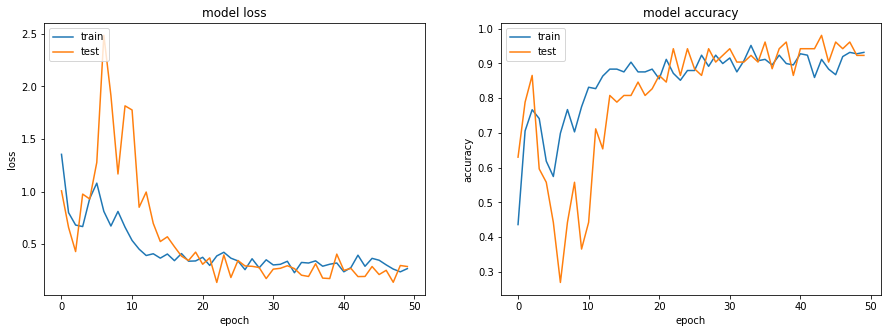

In [70]:
plot_history(history)

- Accuracy and validation accuracy are 92% at 49 and 50th epoch.